In [21]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Sentiment analysis
from textblob import TextBlob

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [22]:
# Load the Kaggle Twitter dataset (adjust path as needed)
df = pd.read_csv(r'C:\Users\hr157\Downloads\Tweets\Tweets.csv')  # For example, "Twitter US Airline Sentiment"

# Display the shape and preview
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


C:\Users\hr157\AppData\Local\Temp\ipykernel_18208\3592047381.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline_sentiment', palette='cool')


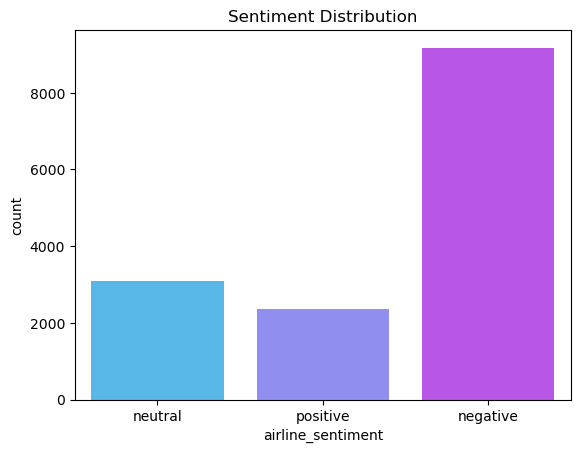

In [23]:
# Check for nulls
print(df.isnull().sum())

# View unique sentiment labels
print(df['airline_sentiment'].value_counts())

# Plot sentiment distribution
sns.countplot(data=df, x='airline_sentiment', palette='cool')
plt.title("Sentiment Distribution")
plt.show()


In [24]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stopwords
    tokens = text.split()
    filtered = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(filtered)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hr157\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


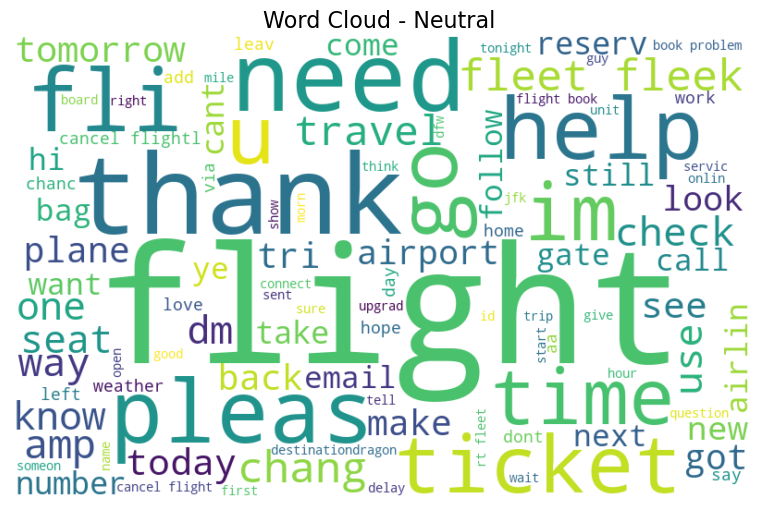

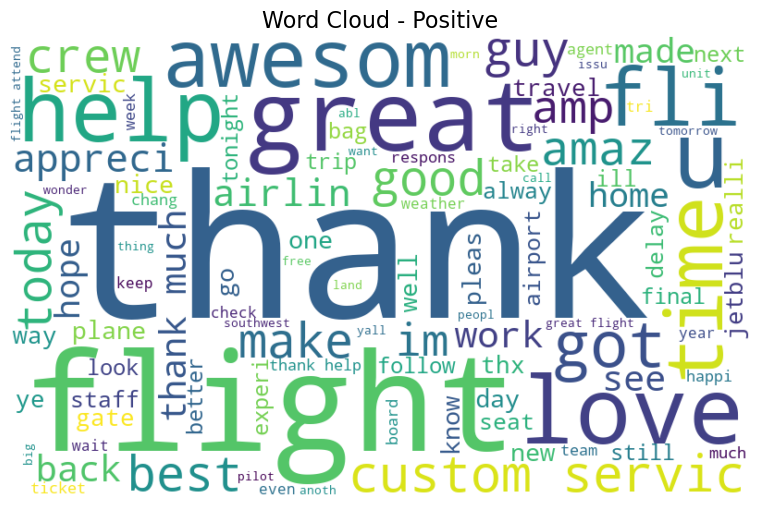

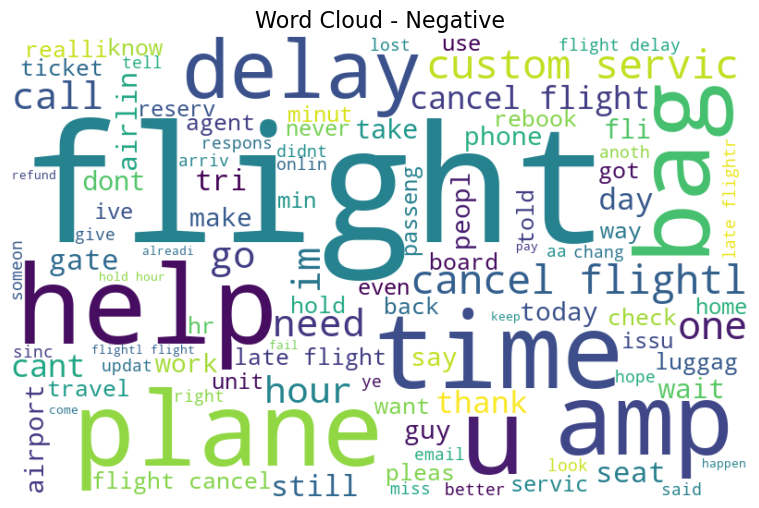

In [25]:
def show_wordcloud(data, title):
    wc = WordCloud(width=800, height=500, max_words=100, background_color='white').generate(" ".join(data))
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Visualize
for sentiment in df['airline_sentiment'].unique():
    show_wordcloud(df[df['airline_sentiment'] == sentiment]['clean_text'], f"Word Cloud - {sentiment.capitalize()}")


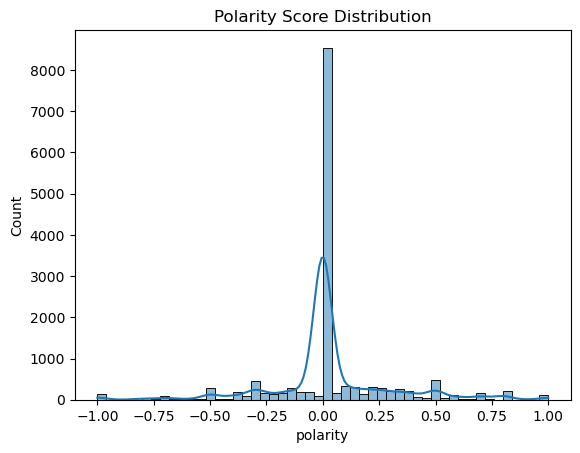

In [26]:
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

df['polarity'] = df['clean_text'].apply(get_sentiment_score)

# Polarity distribution
sns.histplot(df['polarity'], bins=50, kde=True)
plt.title("Polarity Score Distribution")
plt.show()


In [28]:
# Label encoding
df['label'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Split data
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      1835
           1       0.67      0.51      0.58       620
           2       0.81      0.56      0.66       473

    accuracy                           0.79      2928
   macro avg       0.76      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928



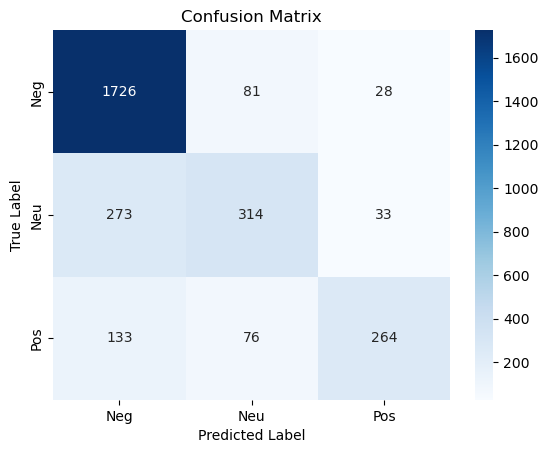

In [29]:
model = LogisticRegression(max_iter=200)
model.fit(X_train_vec, y_train)

# Predict
y_pred = model.predict(X_test_vec)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)

# Heatmap
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


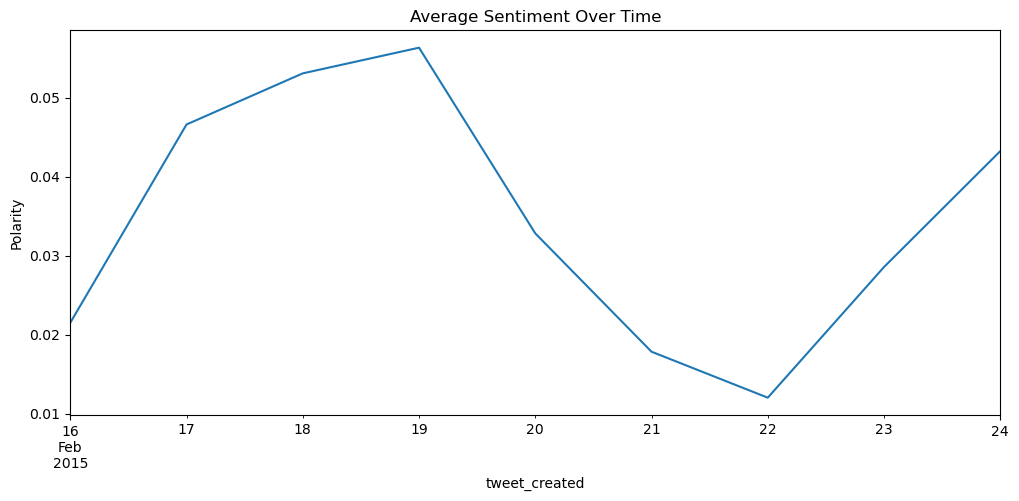

In [30]:
# If dataset has date column
if 'tweet_created' in df.columns:
    df['tweet_created'] = pd.to_datetime(df['tweet_created'])
    df.set_index('tweet_created', inplace=True)
    sentiment_over_time = df.resample('D')['polarity'].mean()
    sentiment_over_time.plot(figsize=(12, 5), title="Average Sentiment Over Time")
    plt.ylabel("Polarity")
    plt.show()


In [32]:
import pickle

# Save model and vectorizer
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
